## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import copy
import numpy
import csv
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
gtf_name = 'Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf'
mutation = 'efp'
my_gene = "rpoB"
samp_num = '1'
#if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
#    pre_load = True
#else:
#    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

## Loading up the csv file.

In [7]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Running the KL divergence on some basic data. 

In [39]:
my_gene = "nlpC"
my_transcript, tr_m, tr_c, index = kat.find_transcripts(my_gene, protein_coding, data_mutant, data_control, )
position = np.array(list(range(len(tr_m))))

In [53]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001, frac = 0.05)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001, frac = 0.05)

In [54]:
for d, i in zip(smoothed_vec_m, list(range(len(smoothed_vec_m)))):
    if d < 0:
        smoothed_vec_m[i] = 0.001

In [55]:
for d, i in zip(smoothed_vec_c, list(range(len(smoothed_vec_c)))):
    if d < 0:
        smoothed_vec_c[i] = 0.001

In [56]:
def KL(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


values1 = [1.346112,1.337432,1.246655]
values2 = [1.033836,1.082015,1.117323]

print(KL(values1, values2))

0.7752796240788413


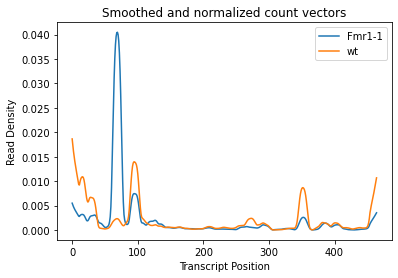

In [57]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

In [60]:
KL(smoothed_vec_c, smoothed_vec_m)

0.760197302665385

In [61]:
stats.entropy(smoothed_vec_m, smoothed_vec_c)

1.210097678986914

Hmmmm, I do not know why lowess smoothing occasionally returns negative values. The negative values are very low and very rare but they do occur. 

In [216]:
for i in smoothed_vec_m:
    if i == 0.000000000000000000001:
        print(i)